# A to Z for plotting a resistivity model from airborne electromagnetic data

Author: Seogi Kang (email: sgkang09@stanford.edu)

## Resources
- Slides: https://bit.ly/aem_plot_slides
- Video: TBA
- Code: https://github.com/envgp/aem_plot

In [ ]:
!pip install -U git+https://github.com/simpeg/simpeg.git@em1d_updates

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from SimPEG.electromagnetics.utils.em1d_utils import Stitched1DModel, plot_layer
from scipy.spatial import cKDTree as KDTree
import matplotlib
matplotlib.rcParams['font.size'] = 14

>> Use cython version


## Step 1: Load the AEM resistivity data

In [2]:
import io
def read_work_bench_xyz_mod(fname):
    with open(fname, 'r') as fid:
        lines = fid.readlines()
    n_header_max = 100
    for ii, line in enumerate(lines):
        if '/' in line:
            pass
        else:
            break

    header = lines[ii-1].split()[1:]
    n_columns = len(header)
    n_sounding = len(lines[ii:])
    data = np.zeros((n_sounding, n_columns))
    for jj, line in enumerate(lines[ii:]):
        data[jj,:] = np.array(line.split(), dtype=float)
    df = pd.DataFrame(data=data, columns=header)
    tmp_thk = np.array(header)[['THK' in header for header in header]]
    thk_names = tmp_thk[:int(len(tmp_thk)/2)]
    tmp_rho = np.array(header)[['RHO' in header for header in header]]
    rho_names = tmp_rho[:int(len(tmp_thk)/2)+1]
    topo = df[['UTMX', 'UTMY', 'ELEVATION']].values[:, :]
    hz = np.unique(df[thk_names].values)
    hz = np.r_[hz, hz[-1]]
    resistivity= df[rho_names].values[:,:]
    line = df['LINE_NO'].values
    return df, topo, hz, resistivity, line

In [3]:
file_name = "../data/Kwh_SCI3i_MOD_inv.xyz"
df, topography, hz, resistivity, line = read_work_bench_xyz_mod(file_name)

In [4]:
df.keys()

Index(['LINE_NO', 'UTMX', 'UTMY', 'TIMESTAMP', 'FID', 'RECORD', 'ELEVATION',
       'ALT', 'INVALT', 'INVALTSTD',
       ...
       'DEP_BOT_STD_32', 'DEP_BOT_STD_33', 'DEP_BOT_STD_34', 'DEP_BOT_STD_35',
       'DEP_BOT_STD_36', 'DEP_BOT_STD_37', 'DEP_BOT_STD_38', 'DEP_BOT_STD_39',
       'DOI_CONSERVATIVE', 'DOI_STANDARD'],
      dtype='object', length=339)

In [5]:
resistivity.shape

(18712, 40)

In [6]:
hz

array([ 3. ,  3.2,  3.4,  3.7,  3.9,  4.2,  4.5,  4.8,  5.1,  5.5,  5.9,
        6.3,  6.7,  7.2,  7.7,  8.2,  8.8,  9.4, 10.1, 10.8, 11.5, 12.3,
       13.2, 14.1, 15. , 16.1, 17.2, 18.4, 19.7, 21.1, 22.5, 24.1, 25.8,
       27.5, 29.5, 31.5, 33.7, 36. , 38.5, 38.5])

In [7]:
topography.shape

(18712, 3)

In [8]:
np.unique(line)

array([ 100102.,  100201.,  100203.,  100301.,  100302.,  100401.,
        100501.,  100601.,  100602.,  100701.,  100801.,  100901.,
        101001.,  101101.,  101202.,  101301.,  101401.,  101501.,
        101601.,  101702.,  101802.,  101901.,  200101.,  200201.,
        200203.,  200301.,  200303.,  200401.,  200501.,  200601.,
        200701.,  200802.,  200901.,  201101.,  201103.,  201201.,
        201202.,  201301.,  201401.,  201501.,  201601.,  201701.,
       2001001.])

In [9]:
resistivity_vec = resistivity.flatten()

In [10]:
resistivity_vec.shape

(748480,)

In [11]:
time_stamp = df['TIMESTAMP'].values

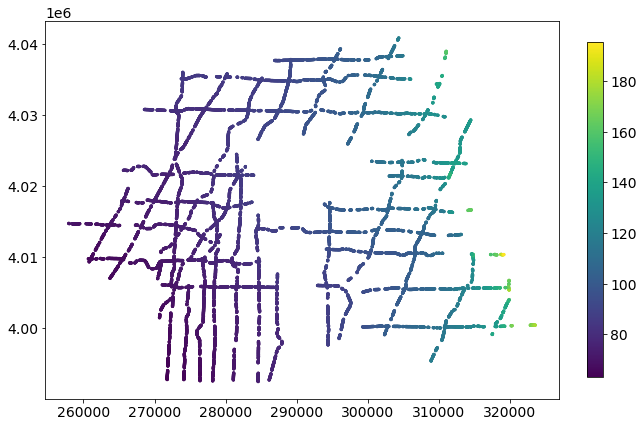

In [12]:
fig  = plt.figure(figsize=(10, 10))
# plt.plot(topography[:,0], topography[:,1], '.', ms=1)
out = plt.scatter(topography[:,0], topography[:,1], c=topography[:,2], s=5)
plt.colorbar(out, fraction=0.03)
plt.gca().set_aspect(1)

## Step 2: Initiate `Stitched1DModel`

In [13]:
resistivity.astype(float)

array([[17.66, 15.51, 13.3 , ..., 39.48, 39.85, 39.86],
       [17.89, 15.29, 12.91, ..., 39.63, 39.94, 39.87],
       [18.24, 14.81, 12.03, ..., 39.71, 39.97, 39.82],
       ...,
       [66.6 , 62.06, 53.09, ..., 24.65, 27.23, 28.88],
       [57.66, 55.21, 48.4 , ..., 24.74, 27.38, 29.15],
       [51.28, 50.58, 45.52, ..., 24.91, 27.62, 29.5 ]])

In [14]:
model = Stitched1DModel(
    topography=topography,
    line=line,
    hz=hz,
    time_stamp=time_stamp, 
    physical_property=resistivity_vec
)

C:\Users\sgkan\anaconda3\envs\aem_plot\lib\site-packages\SimPEG\electromagnetics\utils\em1d_utils.py:531: UserWarning: code under construction - API might change in the future
  warnings.warn(


## Step3: Plot a vertical resistivity profile

In [15]:
from ipywidgets import widgets, interact

Text(0.5, 0, 'Resistivity ($\\Omega$m)')

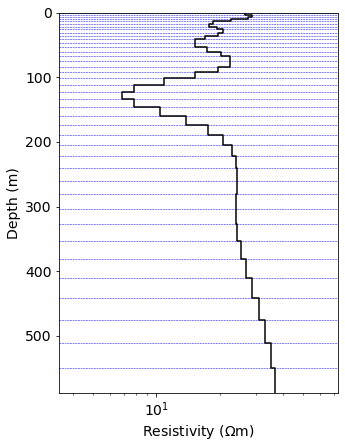

In [19]:
i_sounding = 1000
fig, ax = plt.subplots(1,1, figsize=(5, 7))
plot_layer(resistivity[i_sounding,:], model.mesh_1d, ax=ax, showlayers=True)
ylim = ax.get_ylim()
ax.set_ylim(ylim[1], ylim[0])
ax.set_xlabel("Resistivity ($\Omega$m)")

In [20]:
# TODO: Add this functionality into Stitched1DModel
def interact_plot_layer(i_sounding):
    fig, ax = plt.subplots(1,1, figsize=(5, 7))
    plot_layer(resistivity[i_sounding,:], model.mesh_1d, ax=ax, showlayers=True)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[1], ylim[0])
    ax.set_xlabel("Resistivity ($\Omega$m)")
    ax.set_title("Line number: {:.0f}\n Sounding number: {:.0f}".format(line[i_sounding], i_sounding), fontsize=14)
interact(
    interact_plot_layer, 
    i_sounding=widgets.IntSlider(min=0, max=df.shape[0]-1, step=1, value=0), 
    continuous_update=False
)

interactive(children=(IntSlider(value=0, description='i_sounding', max=18711), Output()), _dom_classes=('widge…

<function __main__.interact_plot_layer(i_sounding)>

## Step 4: Plot a vertical section

In [21]:
# Find unique line numbers
unique_line = np.unique(line)

Text(0.5, 1.0, 'Line number: 100102')

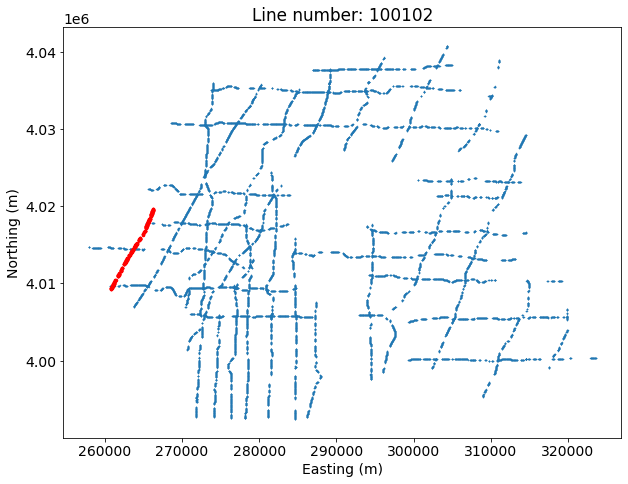

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
i_line = 0
ind_line = line == unique_line[i_line]
ax.plot(topography[:,0], topography[:,1], '.', ms=1)
ax.plot(topography[ind_line,0], topography[ind_line,1], '.', ms=5, color='r')
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Line number: {:.0f}".format(unique_line[i_line]))

In [25]:
def foo(i_line):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ind_line = line == unique_line[i_line]
    ax.plot(topography[:,0], topography[:,1], '.', ms=1)
    ax.plot(topography[ind_line,0], topography[ind_line,1], '.', ms=5, color='r')
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("Line number: {:.0f}".format(unique_line[i_line]))
interact(foo, i_line=widgets.IntSlider(min=0, max=100, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i_line'), Output()), _dom_classes=('widget-interact',))

<function __main__.foo(i_line)>

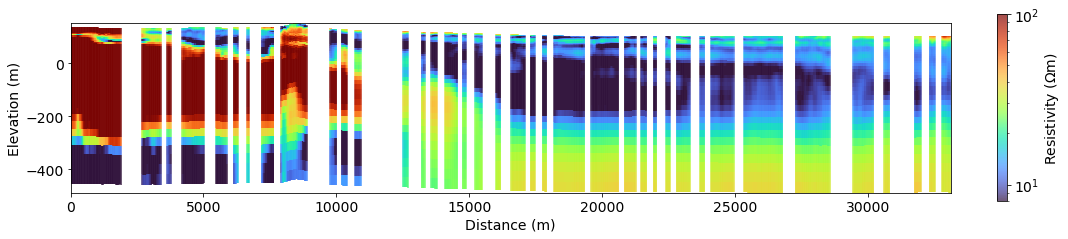

In [26]:
i_line = 11
quad, ax, cb = model.plot_section(i_line=i_line, x_axis='distance', aspect=10, cmap='turbo', clim=(8, 100), dx=20)
cb.set_label("Resistivity ($\Omega$m)")
# ax.set_xlim(0, 1000)

## Step 5: Plot resistivity values of a each layer as points

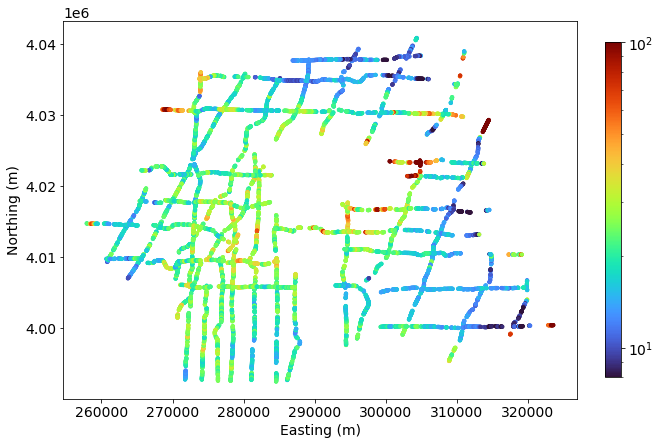

In [27]:
from matplotlib.colors import LogNorm
fig  = plt.figure(figsize=(10, 10))
i_layer = 4
out = plt.scatter(
    topography[:,0], topography[:,1], c=resistivity[:,i_layer], 
    s=10, 
    norm=LogNorm(vmin=8, vmax=100), 
    cmap='turbo'
)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(out, fraction=0.03)
plt.gca().set_aspect(1)

In [28]:
def foo(i_layer):
    fig  = plt.figure(figsize=(10, 10))
    out = plt.scatter(
        topography[:,0], topography[:,1], c=resistivity[:,i_layer], 
        s=10, 
        norm=LogNorm(vmin=8, vmax=100), 
        cmap='turbo'
    )
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.colorbar(out, fraction=0.03)
    plt.gca().set_aspect(1)
    plt.title("{:.0f}-th layer".format(i_layer+1))
interact(foo, i_layer=widgets.IntSlider(min=0, max=39, step=1, value=0))    

interactive(children=(IntSlider(value=0, description='i_layer', max=39), Output()), _dom_classes=('widget-inte…

<function __main__.foo(i_layer)>

## Step 6: Plot resistivity values as a 2D map

In [29]:
from scipy.spatial import cKDTree as KDTree
from verde import distance_mask
def inverse_distance_interpolation(
    xy, values, 
    dx=100, dy=100, x_pad=1000, y_pad=1000,
    power=0, epsilon=None, k_nearest_points=20, 
    max_distance=4000.,
):
    """
        Evaluating 2D inverse distance weighting interpolation
        for given (x, y) points and values.
        
        Inverse distance weight, w, can be written as:
            w = 1/(distance+epsilon)**power
        
        Parameters
        ----------
        xy : array_like
            Input array including (x, y) locations; (n_locations, 2)
        values: array_like
            Input array including values defined at (x, y) locations; (n_locations, )
        dx : int 
            Size of the uniform grid in x-direction
        dy : int 
            Size of the uniform grid in y-direction
        x_pad : float 
            Length of padding in x-direction
        y_pad : float 
            Length of padding in y-direction
        power: float
            Exponent used when evaluating inverse distance weight. 
        epsilon: float
            A floor value used when evaluating inverse distance weight. 
        k_nearest_points: int 
            k-nearest-point used when evaluating inverse distance weight.  
        max_distance: float
            A separation distance used to maks grid points away from the (x, y) locations.
        
        Returns        
        -------
        

    """
    xmin, xmax = xy[:,0].min()-x_pad, xy[:,0].max()+x_pad
    ymin, ymax = xy[:,1].min()-y_pad, xy[:,1].max()+y_pad

    nx = int((xmax-xmin) / dx)
    ny = int((ymax-ymin) / dy)
    hx = np.ones(nx) * dx
    hy = np.ones(ny) * dy
    x = np.arange(nx)*dx + xmin
    y = np.arange(ny)*dy + ymin
    X, Y = np.meshgrid(x, y)

    tree = KDTree(xy)

    d, inds_idw = tree.query(np.c_[X.flatten(), Y.flatten()], k=int(k_nearest_points))
    if epsilon is None:
        epsilon = np.min([dx, dy])
    w = 1.0 / ((d+epsilon) ** power)
    values_idw = (np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1))
    mask_inds = ~distance_mask(
        (xy[:,0], xy[:,1]), maxdist=max_distance, coordinates=(X.flatten(), Y.flatten())
    )
    values_idw[mask_inds] = np.nan
    values_idw = values_idw.reshape(X.shape)
    return x, y, values_idw

ModuleNotFoundError: No module named 'verde'

In [ ]:
i_layer = 10
x, y, values_idw = inverse_distance_interpolation(
    topography[:,:2], resistivity[:,i_layer], 
    dx=200, dy=200,
    max_distance=4000., k_nearest_points=100, power=1
)

In [ ]:
values_idw.shape

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
depth = np.cumsum(np.r_[0., hz])
out = plt.pcolormesh(x, y, values_idw, norm=LogNorm(vmin=8, vmax=100), 
    cmap='turbo'
)
ax.plot(topography[:,0], topography[:,1], 'k.', ms=0.001)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
cb = plt.colorbar(out)
cb.set_label('Resistivity ($\Omega$m)')
ax.grid(True, alpha=0.5)
ax.set_aspect(1)
ax.set_title("Depth at {:.1f} m".format(depth[i_layer]), fontsize=14)

## Step 7: Plot the resistivity model in 3D
- Export to files to be visualized in Leapfrog

In [ ]:
from SimPEG import utils
def write_aem_leapfrog_csv(
    hz, Line, topography, properties,
    name_properties=['resistivity'],
    nskip=1, work_dir='./', fname_header=''
):

    n_sounding_all = topography.shape[0]
    stitched_model = Stitched1DModel(
        hz=hz,
        line=Line[::nskip],
        topography=topography[::nskip,:].copy()
    )
    depth_from = np.zeros((hz.size, stitched_model.n_sounding), order='F')
    depth_to = np.zeros((hz.size, stitched_model.n_sounding), order='F')

    # collar information
    lineid_collar = Line[::nskip]
    wellid_collar = np.arange(lineid_collar.size) + 1

    north_collar = stitched_model.topography[:,1]
    east_collar = stitched_model.topography[:,0]
    depth_max_collar = np.ones_like(wellid_collar) * hz.sum()
    elevation_collar = stitched_model.topography[:,2]

    # interval information

    for ii in range(stitched_model.n_sounding):
        depth_from[:,ii] = stitched_model.mesh_1d.vectorNx[:-1]
        depth_to[:,ii] = stitched_model.mesh_1d.vectorNx[1:]

    lineid = stitched_model.line.repeat(hz.size)
    wellid = wellid_collar.repeat(hz.size)
    east = utils.mkvc(stitched_model.xyz[:,0])
    north = utils.mkvc(stitched_model.xyz[:,1])
    depth_from = utils.mkvc(depth_from[:,:])
    depth_to = utils.mkvc(depth_to[:,:])

    df_collar = pd.DataFrame(data=np.c_[wellid_collar, stitched_model.line, east_collar, north_collar, elevation_collar, depth_max_collar], columns=['wellid', 'Line', 'X', 'Y', 'elevation', 'depth'])
    df_collar.to_csv(work_dir+'collar-{:s}.csv'.format(fname_header), index=False)


    distance_collar = np.zeros_like(wellid_collar)
    azimuth_collar = np.zeros_like(wellid_collar)
    dip_collar = np.ones_like(wellid_collar) * 90.

    df_survey = pd.DataFrame(data=np.c_[wellid_collar, distance_collar, azimuth_collar, dip_collar], columns=['wellid', 'distance', 'azimuth', 'dip'])
    df_survey.to_csv(work_dir+'survey-{:s}.csv'.format(fname_header), index=False)
    data = np.c_[wellid, depth_from, depth_to]
    for ii in range (len(name_properties)):
        data = np.c_[data, properties[:,ii].reshape((n_sounding_all, hz.size))[::nskip, :].flatten()]
    df_interval = pd.DataFrame(
        data=data,
        columns=['wellid', 'from', 'to'] + name_properties
    )
    df_interval.to_csv(work_dir+'interval-{:s}.csv'.format(fname_header), index=False)
    return df_collar, df_survey, df_interval

In [30]:
df_collar, df_survey, df_interval = write_aem_leapfrog_csv(
    hz, line, topography, resistivity.flatten().reshape([-1,1]),
    name_properties=['resistivity'],
    nskip=10, work_dir='./', fname_header='kaweah'
)

NameError: name 'write_aem_leapfrog_csv' is not defined

In [ ]:
!ls

## Step 8: Plot the resistivity model in as a 3D grid
- Interpolate the resistivity model to a 3D grid
- Export to files to be visualized in Paraview

In [ ]:
model.get_3d_mesh()

In [ ]:
model.get_interpolation_matrix(npts=100)

In [ ]:
from verde import distance_mask
resistivity_3d = model.interpolate_from_1d_to_3d(resistivity_vec)
mask = distance_mask(
    (topography[:,0], topography[:,1]), 
    maxdist=3000, 
    coordinates=(model.mesh_3d.gridCC[:,0], model.mesh_3d.gridCC[:,1])
)
resistivity_3d = resistivity_3d.flatten(order='F')
resistivity_3d[~mask] = np.nan

In [ ]:
resistivity_3d.shape

In [ ]:
model.mesh_3d.n_cells

In [ ]:
model.mesh_3d.write_UBC("mesh.msh")

In [ ]:
model.mesh_3d.write_model_UBC("model.mod", resistivity_3d)

In [ ]:
model.mesh_3d.write_vtk("model.vtr", models={'resistivity':resistivity_3d})

In [ ]:
!ls

# Questions?